# Comprehensive Generative AI Model Evaluation

This notebook provides a unified framework for evaluating both **Text** and **Image** generative models. It combines classical NLP metrics with state-of-the-art computer vision evaluation techniques.

### Modalities Covered:
1. **Text Modality:** Evaluates models (e.g., GPT vs. Gemini) on Translation and Summarization using **BLEU**, **ROUGE**, and **Perplexity**.
2. **Image Modality:** Evaluates image generation models (Model A vs. Model B) using **CLIPScore** (text-image alignment), **FID** (realism vs. real images), **Inception Score (IS)**, and structured **Human Ratings**.

--- 
## Setup & Installations

In [1]:
!pip -q install evaluate rouge_score pandas transformers torch torchmetrics tabulate
!pip -q install ftfy regex tqdm
!pip -q install https://github.com/openai/CLIP/archive/refs/heads/main.zip
!pip -q install pytorch-fid

--- 
## 2. Part 1: Text Model Evaluation
Evaluating Translation and Summarization tasks using automated NLP metrics.

In [2]:
import pandas as pd
import evaluate
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import warnings
from IPython.display import display, HTML

warnings.filterwarnings('ignore')

def calculate_classic_metrics(
    references: list[list[str]], 
    predictions_dict: dict[str, list[str]],
    evaluator_model_id: str = "gpt2"
) -> pd.DataFrame:
    """
    Computes BLEU and ROUGE using 'evaluate', and Perplexity manually via 'transformers'.
    """
    bleu = evaluate.load("bleu")
    rouge = evaluate.load("rouge")

    tokenizer = AutoTokenizer.from_pretrained(evaluator_model_id)
    tokenizer.pad_token = tokenizer.eos_token 
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = AutoModelForCausalLM.from_pretrained(evaluator_model_id).to(device)
    model.eval()

    def get_perplexity(texts):
        ppl_scores = []
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt").to(device)
            with torch.no_grad():
                loss = model(inputs.input_ids, labels=inputs.input_ids).loss
                ppl_scores.append(torch.exp(loss).item())
        return sum(ppl_scores) / len(ppl_scores) if ppl_scores else 0.0

    results = []
    for model_name, predictions in predictions_dict.items():
        bleu_score = bleu.compute(predictions=predictions, references=references)
        rouge_score = rouge.compute(predictions=predictions, references=references)
        perp_score = get_perplexity(predictions)
        
        results.append({
            "Model": model_name,
            "BLEU": bleu_score.get("bleu", 0.0),
            "ROUGE-L": rouge_score.get("rougeL", 0.0),
            "Perplexity": perp_score
        })

    return pd.DataFrame(results)

c:\Users\hp\lora-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = {
    "task_type": ["Translation", "Summarization"],
    "prompt": [
        "Translate the following legal clause from English to Arabic:'Without prejudice to the terms and conditions hereof...",
        "Summarize the article above in exactly three sentences, focusing on the main event, the key stakeholders, and the final outcome."
    ],
    "reference": [
        "مع عدم الإخلال بما جاء بشروط هذا العقد، يعتبر هذا العقد مفسوخًا من تلقاء نفسه بدون الحاجة إلى إخطار أو تنبيه أو اتخاذ إجراءات قانونية متى أخل أي طرف بأي من التزاماته بموجب هذا العقد ويحق للطرف الثاني الرجوع عليه بالتعويضات المناسبة.اذا تخلف المشتري عن التزاماته بموجب هذا العقد أو أخل بها يحق للبائع استلام واحتجاز العربون كتعويض متفق عليه.",
        "In today’s digital era where screens and keyboards dominate, we often underestimate the importance of handwriting.Experts say that handwriting plays a key role in cognitive development, memory retention, and academic performance..."
    ],
    "gpt_output": [
        "مع عدم الإخلال بالشروط والأحكام الواردة في هذا العقد، يُعدّ هذا العقد مفسوخًا تلقائيًا دون حاجة إلى إخطار أو إنذار...",
        "Handwriting remains important in a digital age because it supports cognitive development, memory retention, and academic performance in children..."
    ],
    "gemini_output": [
        "مع عدم الإخلال بالشروط والأحكام الواردة في هذا العقد، يُفسخ هذا العقد تلقائياً دون الحاجة إلى إنذار أو إعذار...",
        "In an increasingly digital world, children and educators are the primary focus of research highlighting the critical necessity of maintaining traditional handwriting skills..."
    ]
}

df_data = pd.DataFrame(data)


In [4]:

task_types = df_data['task_type'].unique()

for task in task_types:
    task_df = df_data[df_data['task_type'] == task]
    target_references = [[ref] for ref in task_df["reference"].tolist()]
    model_outputs = {
        "GPT": task_df["gpt_output"].tolist(),
        "Gemini": task_df["gemini_output"].tolist()
    }
    
    comparison_df = calculate_classic_metrics(references=target_references, predictions_dict=model_outputs)

    display(HTML(f"<h3>Text Metrics Results for: {task}</h3>"))
    display(comparison_df)
    print("\n")

Loading weights: 100%|██████████| 148/148 [00:00<00:00, 482.99it/s, Materializing param=transformer.wte.weight]             
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


,Model,BLEU,ROUGE-L,Perplexity
0,GPT,0.0,0.0,9.509959
1,Gemini,0.0,0.0,9.046852


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 683.06it/s, Materializing param=transformer.wte.weight]             


,Model,BLEU,ROUGE-L,Perplexity
0,GPT,0.219409,0.346154,80.300705
1,Gemini,0.000000,0.214286,104.670212


--- 
## 3. Part 2: Image Model Evaluation
Evaluating visual generative models using Computer Vision metrics and Human assessment forms.

**Required Folder Structure:**
```text
data/
  prompts.csv
  real_images/              # (real reference images for FID)
  modelA/                   # Generated images from Model A
  modelB/                   # Generated images from Model B
outputs/
```

In [5]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
import clip
from pytorch_fid import fid_score
import torchvision.transforms as TF
from torchmetrics.image.inception import InceptionScore

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Vision Evaluation Device:", DEVICE)

DATA_DIR = Path("data")
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

modelA_dir = DATA_DIR / "modelA"
modelB_dir = DATA_DIR / "modelB"
real_dir = DATA_DIR / "real_images"


prompts_path = DATA_DIR / "prompts.csv"
if prompts_path.exists():
    df_img = pd.read_csv(prompts_path)
    def build_path(base_dir, fname):
        p = base_dir / str(fname)
        return p if p.exists() else None

    df_img["pathA"] = df_img["imgA"].apply(lambda x: build_path(modelA_dir, x))
    df_img["pathB"] = df_img["imgB"].apply(lambda x: build_path(modelB_dir, x))
    display(df_img.head())
else:
    print(f"Skipping image data load: {prompts_path} not found.")

Vision Evaluation Device: cpu


,id,prompt,imgA,imgB,pathA,pathB
0,1,A vibrant harbor scene with a small orange boa...,1.png,1.png,data\modelA\1.png,data\modelB\1.png
1,2,Traditional Saudi Arabian architecture with en...,2.png,2.png,data\modelA\2.png,data\modelB\2.png
2,3,A sea turtle swimming underwater + in the styl...,3.png,3.png,data\modelA\3.png,data\modelB\3.png
3,4,A wide snowy alpine slope with two distant ski...,4.png,4.png,data\modelA\4.png,data\modelB\4.png
4,5,An asphalt road winding through massive sand d...,5.png,5.png,data\modelA\5.png,data\modelB\5.png


### 3.1 CLIPScore (Text–Image Alignment)
Computes cosine similarity between CLIP text embeddings and image embeddings. Higher is better.

In [6]:
if prompts_path.exists():
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=DEVICE)

    @torch.no_grad()
    def clip_score(image_path: Path, text: str) -> float:
        if image_path is None or not image_path.exists(): return 0.0
        image = clip_preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(DEVICE)
        text_tokens = clip.tokenize([text]).to(DEVICE)
        img_feat = clip_model.encode_image(image)
        txt_feat = clip_model.encode_text(text_tokens)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
        txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)
        return float((img_feat @ txt_feat.T).cpu().item())

    scoresA, scoresB = [], []
    for _, row in df_img.iterrows():
        scoresA.append(clip_score(row["pathA"], row["prompt"]))
        scoresB.append(clip_score(row["pathB"], row["prompt"]))

    df_img["CLIP_A"] = scoresA
    df_img["CLIP_B"] = scoresB

    clip_avg_A = df_img["CLIP_A"].mean()
    clip_avg_B = df_img["CLIP_B"].mean()
    print(f"Avg CLIPScore — Model A: {clip_avg_A:.4f}")
    print(f"Avg CLIPScore — Model B: {clip_avg_B:.4f}")
    df_img.to_csv(OUT_DIR / "clip_scores.csv", index=False)

Avg CLIPScore — Model A: 0.3367
Avg CLIPScore — Model B: 0.3285


### 3.2 FID (Fréchet Inception Distance)
Compares the feature distribution of real images against generated images. Lower is better.

In [7]:
fid_A, fid_B = None, None
if real_dir.exists() and any(real_dir.iterdir()):
    fid_A = fid_score.calculate_fid_given_paths([str(real_dir), str(modelA_dir)], batch_size=1, device=DEVICE, dims=2048)
    fid_B = fid_score.calculate_fid_given_paths([str(real_dir), str(modelB_dir)], batch_size=1, device=DEVICE, dims=2048)
    print(f"FID — Model A: {fid_A:.2f}")
    print(f"FID — Model B: {fid_B:.2f}")
else:
    print("Skipping FID: No real images found in data/real_images.")

100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


FID — Model A: 191.79
FID — Model B: 211.83


### 3.3 Inception Score (IS)
Evaluates the quality and diversity of generated images (does not require real images). Higher is better.

In [8]:
inception_score_metric = InceptionScore(splits=1).to(DEVICE)
transform = TF.Compose([TF.Resize((299, 299)), TF.PILToTensor()])

def calculate_is(folder_path):
    if not folder_path.exists(): return 0.0
    image_paths = list(folder_path.glob("*.png")) + list(folder_path.glob("*.jpg"))
    if not image_paths: return 0.0
    
    imgs = [transform(Image.open(p).convert("RGB")) for p in image_paths]
    imgs_batch = torch.stack(imgs).to(DEVICE)
    
    inception_score_metric.update(imgs_batch)
    mean, std = inception_score_metric.compute()
    inception_score_metric.reset() 
    return mean.item()

is_A = calculate_is(modelA_dir)
is_B = calculate_is(modelB_dir)
print(f"Inception Score (IS) — Model A: {is_A:.2f}")
print(f"Inception Score (IS) — Model B: {is_B:.2f}")

Inception Score (IS) — Model A: 5.88
Inception Score (IS) — Model B: 6.15


### 3.4 Human Ratings Template Generation & Mini Report
Generates a template for subjective manual evaluation (Realism, Prompt Accuracy, Aesthetics) and creates a consolidated markdown report.

In [9]:
if prompts_path.exists():
    # 1. Create Human Rating Template
    rows = []
    for _, r in df_img.iterrows():
        rows.append({"id": r["id"], "model": "A", "prompt": r["prompt"], "image": str(r["pathA"]), "realism_1_5": "", "prompt_acc_1_5": "", "aesthetic_1_5": "", "notes": ""})
        rows.append({"id": r["id"], "model": "B", "prompt": r["prompt"], "image": str(r["pathB"]), "realism_1_5": "", "prompt_acc_1_5": "", "aesthetic_1_5": "", "notes": ""})
    
    human_df = pd.DataFrame(rows)
    human_df.to_csv(OUT_DIR / "human_ratings_template.csv", index=False)
    
    # 2. Build Summary DataFrame
    summary = {
        "Metric": ["Avg CLIPScore (↑)", "FID vs Real (↓)", "Inception Score (↑)"],
        "Model A": [clip_avg_A, fid_A, is_A],
        "Model B": [clip_avg_B, fid_B, is_B],
    }
    summary_df = pd.DataFrame(summary)

    # 3. Export Markdown Report
    report_lines = [
        "# Mini Report — Model A vs Model B (Image Generation)\n",
        "## Setup\n",
        "- Metrics: CLIPScore, FID, Inception Score (IS), Human ratings\n",
        "## Results\n",
        summary_df.to_markdown(index=False),
        "\n\n## Interpretation\n",
        "- Higher **CLIPScore** = Better prompt alignment.\n",
        "- Lower **FID** = More realism + diversity vs real images.\n",
        "- Higher **Inception Score (IS)** = Better image quality and diversity.\n"
    ]
    
    md_path = OUT_DIR / "mini_report.md"
    md_path.write_text("\n".join(report_lines), encoding="utf-8")
    
    print(f"Template saved to: outputs/human_ratings_template.csv")
    print(f"Report saved to: {md_path}")
    display(summary_df)

Template saved to: outputs/human_ratings_template.csv
Report saved to: outputs\mini_report.md


,Metric,Model A,Model B
0,Avg CLIPScore (↑),0.336664,0.328465
1,FID vs Real (↓),191.788091,211.832174
2,Inception Score (↑),5.877502,6.147103


## 4) Reslut visualization

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(15,20))


<Figure size 1500x2000 with 0 Axes>

## 4.1) Text Evaluation: BLEU & ROUGE-L (Subplot 1)

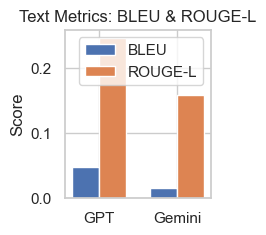

In [11]:
ax1 = plt.subplot(2, 3, 1)
text_models = ['GPT', 'Gemini']
bleu_scores = [0.048, 0.015] 
rouge_scores = [0.247, 0.159] 
x = np.arange(len(text_models))
width = 0.35

ax1.bar(x - width/2, bleu_scores, width, label='BLEU', color='#4C72B0')
ax1.bar(x + width/2, rouge_scores, width, label='ROUGE-L', color='#DD8452')
ax1.set_ylabel('Score')
ax1.set_title('Text Metrics: BLEU & ROUGE-L')
ax1.set_xticks(x)
ax1.set_xticklabels(text_models)
ax1.legend()


## 4.2) Text Evaluation: Perplexity (Subplot 2)

Text(0.5, 1.0, 'Text Metrics: Perplexity')

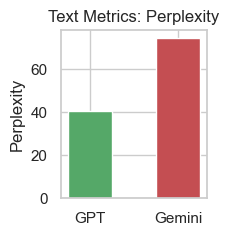

In [12]:

ax2 = plt.subplot(2, 3, 2)
perplexity_scores = [40.5, 74.7] 
ax2.bar(text_models, perplexity_scores, color=['#55A868', '#C44E52'], width=0.5)
ax2.set_ylabel('Perplexity')
ax2.set_title('Text Metrics: Perplexity')


## 4.3) Image Evaluation: CLIPScore & IS (Subplot 3)

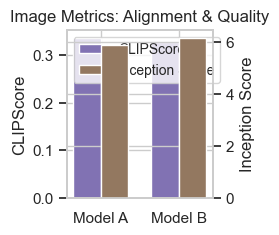

In [13]:
ax3 = plt.subplot(2, 3, 3)
img_models = ['Model A', 'Model B']

if 'clip_avg_A' not in locals():
    clip_avg_A, clip_avg_B = 0.336664,0.328465

if 'is_A' not in locals():
    is_A, is_B = 5.88, 6.15            

clip_scores = [clip_avg_A, clip_avg_B]
is_scores = [is_A, is_B]

x = np.arange(len(img_models))
width = 0.35

ax3_2 = ax3.twinx()  # Dual axis since scales are different
ax3.bar(x - width/2, clip_scores, width, label='CLIPScore', color='#8172B3')
ax3_2.bar(x + width/2, is_scores, width, label='Inception Score', color='#937860')

ax3.set_ylabel('CLIPScore')
ax3_2.set_ylabel('Inception Score')
ax3.set_title('Image Metrics: Alignment & Quality')
ax3.set_xticks(x)
ax3.set_xticklabels(img_models)

# Combine legends from both axes
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_2.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc='upper left', fontsize='small')


## 4.4) Image Evaluation: FID Score (Subplot 4)


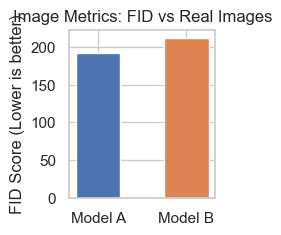

In [14]:
ax4 = plt.subplot(2, 3, 4)

# Ensure fid_A and fid_B are numbers, otherwise default to 0 for the plot
plot_fid_A = fid_A if fid_A is not None else 0
plot_fid_B = fid_B if fid_B is not None else 0

fid_scores = [plot_fid_A, plot_fid_B]
img_models = ['Model A', 'Model B']

ax4.bar(img_models, fid_scores, color=['#4C72B0', '#DD8452'], width=0.5)
ax4.set_ylabel('FID Score (Lower is better)')
ax4.set_title('Image Metrics: FID vs Real Images')

# Add a text warning if data was missing
if fid_A is None or fid_B is None:
    ax4.text(0.5, 0.5, 'FID Data Missing\n(Check data/real_images)', 
             ha='center', va='center', transform=ax4.transAxes, color='red')

## 4.5). Human Evaluation: Radar Chart (Subplot 5)

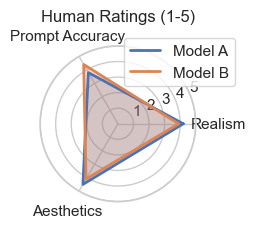

In [15]:
try:
    ax5 = plt.subplot(2, 3, 5, polar=True)
    categories = ['Realism', 'Prompt Accuracy', 'Aesthetics']
    N = len(categories)
    
    # Mocking human average data - replace with your 'human_avg' variable
    values_A = [4.2, 3.8, 4.5] 
    values_B = [3.9, 4.4, 4.1]
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    values_A += values_A[:1]
    values_B += values_B[:1]
    angles += angles[:1]
    
    ax5.plot(angles, values_A, linewidth=2, linestyle='solid', label='Model A')
    ax5.fill(angles, values_A, alpha=0.25)
    
    ax5.plot(angles, values_B, linewidth=2, linestyle='solid', label='Model B')
    ax5.fill(angles, values_B, alpha=0.25)
    
    plt.xticks(angles[:-1], categories)
    ax5.set_ylim(0, 5)
    ax5.set_title('Human Ratings (1-5)')
    ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
except Exception as e:
    plt.subplot(2, 3, 5)
    plt.text(0.5, 0.5, 'Fill out human_ratings_filled.csv\\nto view Radar Chart', ha='center', va='center')

plt.tight_layout()
plt.show()

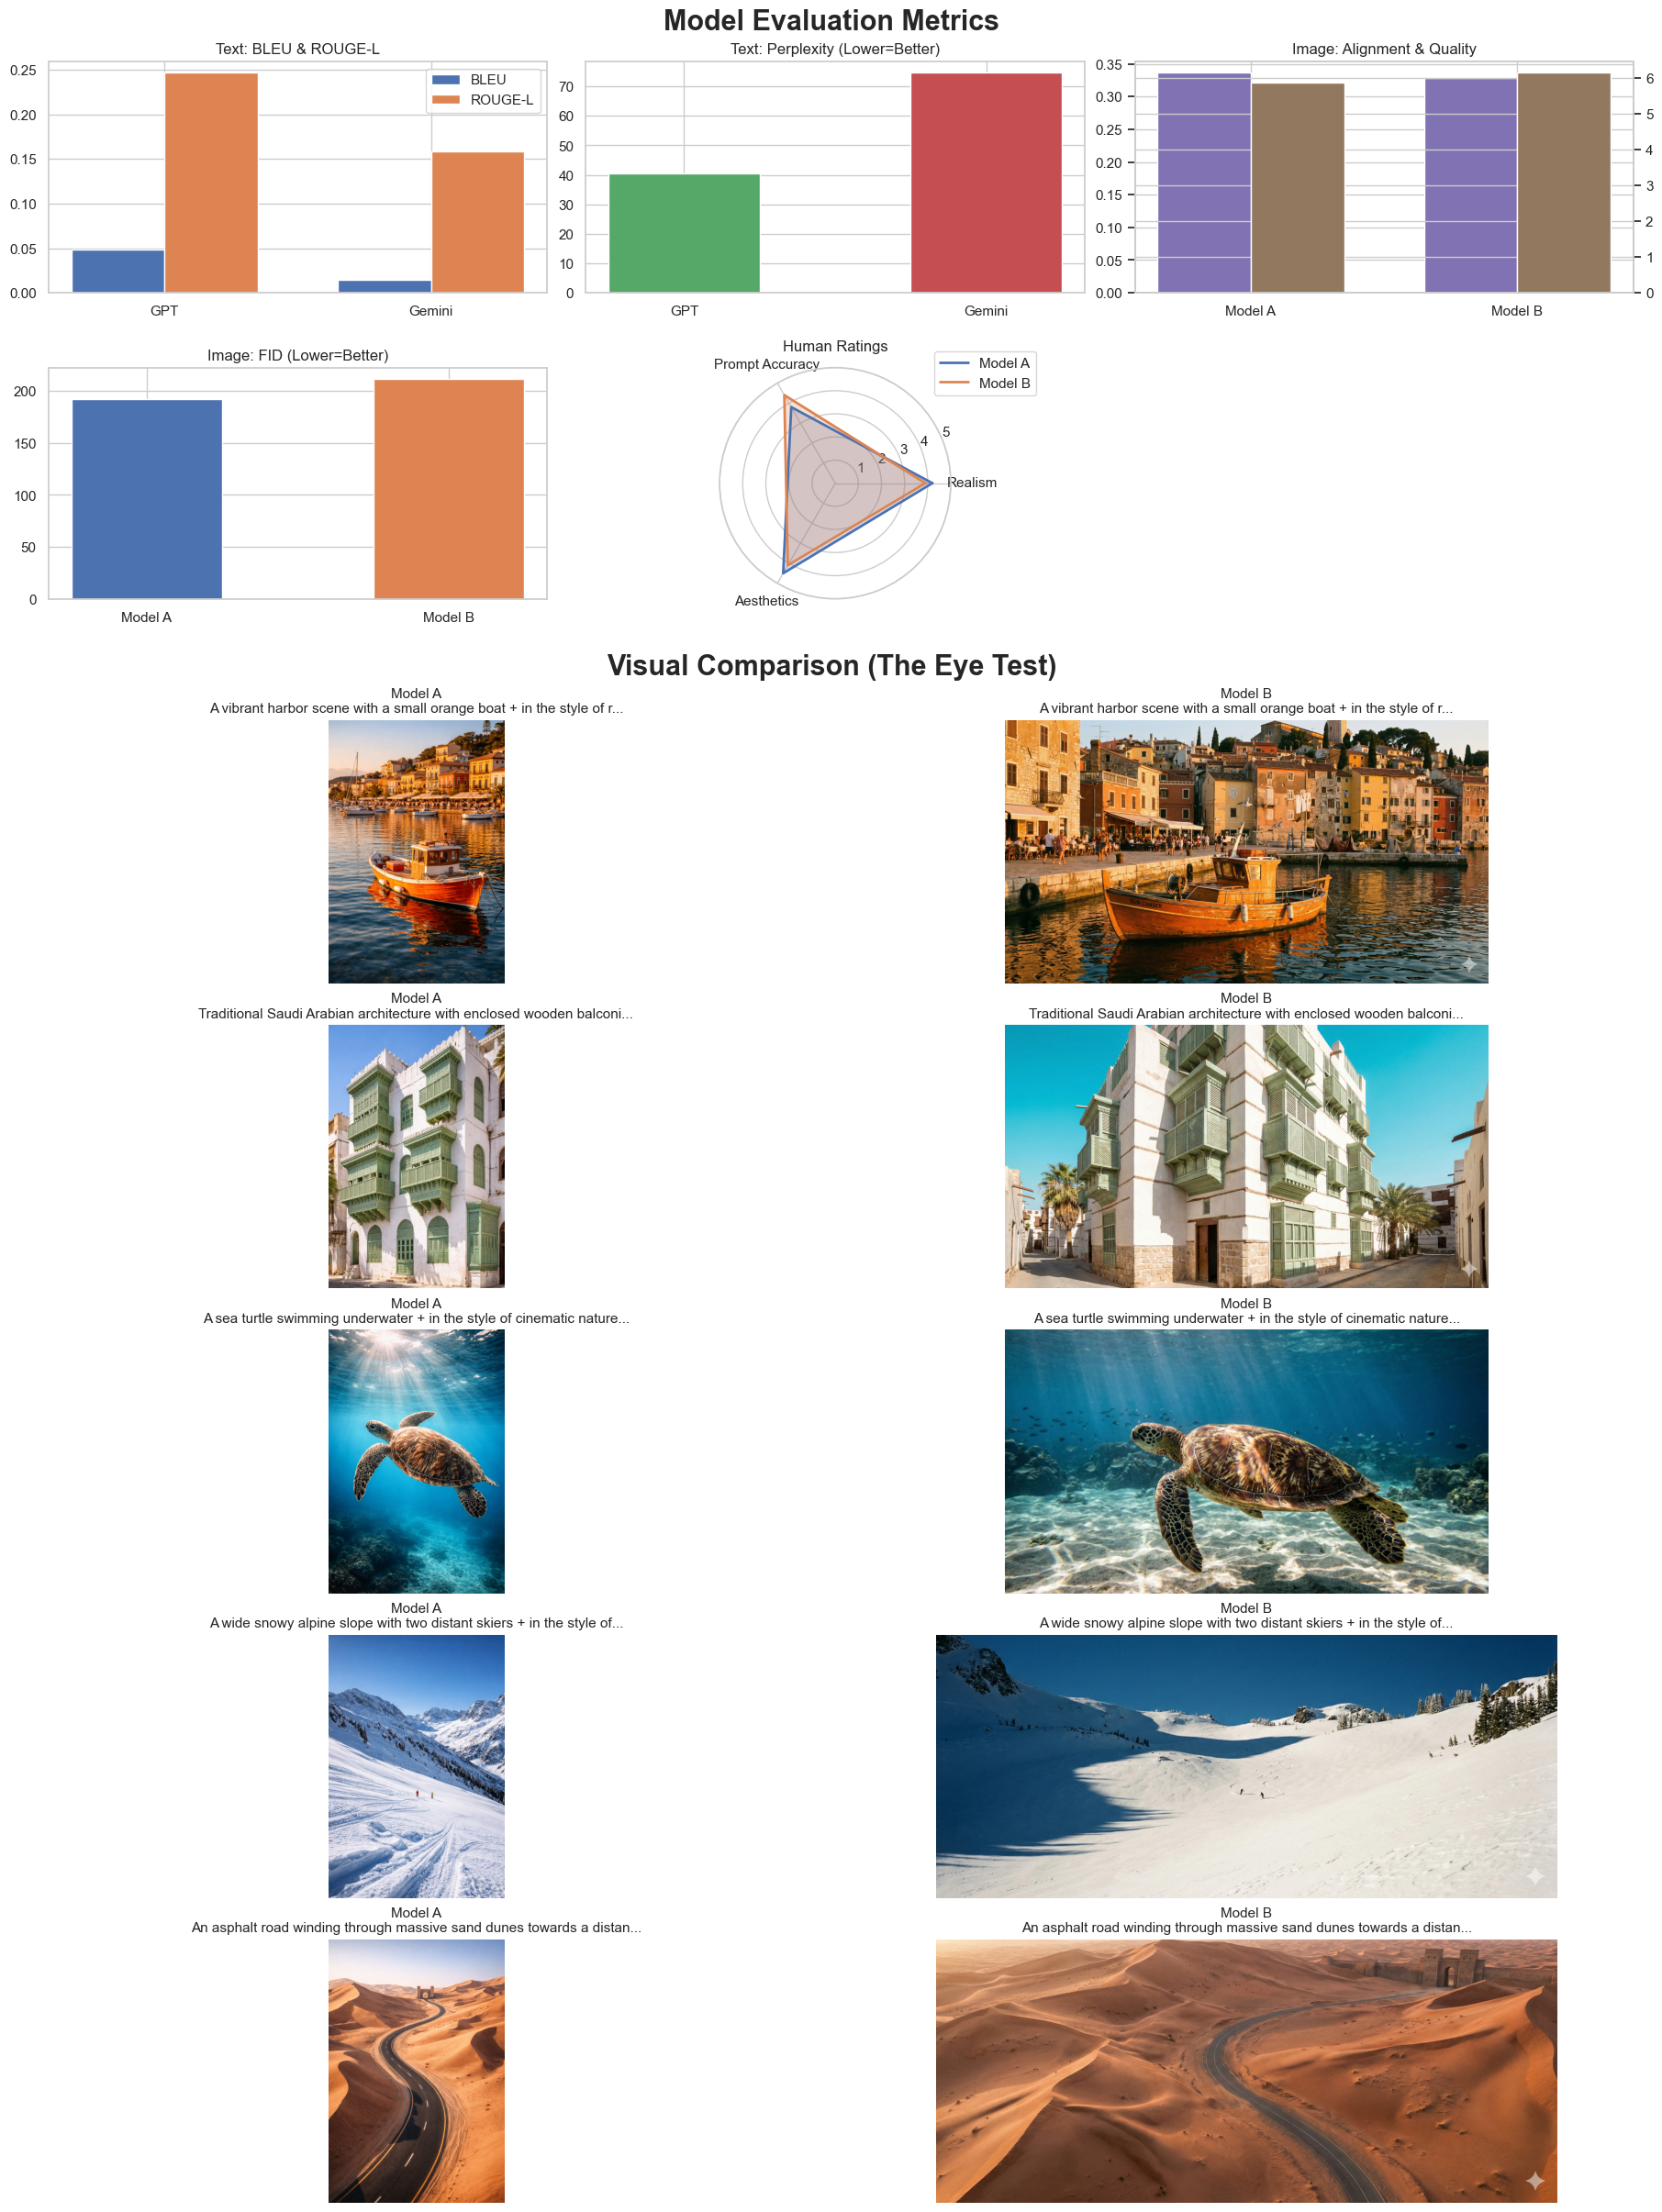

In [16]:

from PIL import Image

# 1. Safety nets for variables (uses your real data if available)
_clip_A = locals().get('clip_avg_A', 0.336)
_clip_B = locals().get('clip_avg_B', 0.328)
_is_A = locals().get('is_A', 5.88)
_is_B = locals().get('is_B', 6.15)
_fid_A = locals().get('fid_A', 191.7)
_fid_B = locals().get('fid_B', 211.8)

sns.set_theme(style="whitegrid")

# 2. Setup Master Figure (18 inches wide, 24 inches tall)
fig = plt.figure(figsize=(18, 24), constrained_layout=True)

# Split the master figure into top (charts) and bottom (images)
subfigs = fig.subfigures(2, 1, height_ratios=[1, 2.5])

# ==========================================
# TOP SECTION: METRICS 
# ==========================================
subfigs[0].suptitle('Model Evaluation Metrics', fontsize=22, fontweight='bold')

# Create the 5 subplots manually so we can make the last one a radar chart
ax1 = subfigs[0].add_subplot(2, 3, 1)
ax2 = subfigs[0].add_subplot(2, 3, 2)
ax3 = subfigs[0].add_subplot(2, 3, 3)
ax4 = subfigs[0].add_subplot(2, 3, 4)
ax5 = subfigs[0].add_subplot(2, 3, 5, polar=True)

# --- Subplot 1: BLEU & ROUGE ---
text_models = ['GPT', 'Gemini']
x = np.arange(len(text_models))
width = 0.35
ax1.bar(x - width/2, [0.048, 0.015], width, label='BLEU', color='#4C72B0')
ax1.bar(x + width/2, [0.247, 0.159], width, label='ROUGE-L', color='#DD8452')
ax1.set_title('Text: BLEU & ROUGE-L')
ax1.set_xticks(x)
ax1.set_xticklabels(text_models)
ax1.legend()

# --- Subplot 2: Perplexity ---
ax2.bar(text_models, [40.5, 74.7], color=['#55A868', '#C44E52'], width=0.5)
ax2.set_title('Text: Perplexity (Lower=Better)')

# --- Subplot 3: CLIP & IS ---
img_models = ['Model A', 'Model B']
ax3_2 = ax3.twinx() 
ax3.bar(x - width/2, [_clip_A, _clip_B], width, label='CLIPScore', color='#8172B3')
ax3_2.bar(x + width/2, [_is_A, _is_B], width, label='Inception', color='#937860')
ax3.set_title('Image: Alignment & Quality')
ax3.set_xticks(x)
ax3.set_xticklabels(img_models)

# --- Subplot 4: FID ---
ax4.bar(img_models, [_fid_A, _fid_B], color=['#4C72B0', '#DD8452'], width=0.5)
ax4.set_title('Image: FID (Lower=Better)')

# --- Subplot 5: Human Radar ---
categories = ['Realism', 'Prompt Accuracy', 'Aesthetics']
N = len(categories)
values_A = [4.2, 3.8, 4.5] + [4.2] 
values_B = [3.9, 4.4, 4.1] + [3.9]
angles = [n / float(N) * 2 * np.pi for n in range(N)] + [0]

ax5.plot(angles, values_A, linewidth=2, linestyle='solid', label='Model A')
ax5.fill(angles, values_A, alpha=0.25)
ax5.plot(angles, values_B, linewidth=2, linestyle='solid', label='Model B')
ax5.fill(angles, values_B, alpha=0.25)
ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(categories)
ax5.set_ylim(0, 5)
ax5.set_title('Human Ratings')
ax5.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))

# ==========================================
# BOTTOM SECTION: IMAGE GRID 
# ==========================================
subfigs[1].suptitle('Visual Comparison (The Eye Test)', fontsize=22, fontweight='bold')

num_prompts = 5
has_data = 'df_img' in locals()
img_axs = subfigs[1].subplots(num_prompts, 2)

for i in range(num_prompts):
    ax_a = img_axs[i, 0]
    ax_b = img_axs[i, 1]
    ax_a.axis('off')
    ax_b.axis('off')
    
    if has_data and i < len(df_img):
        row = df_img.iloc[i]
        
        # Open images safely
        img_a = Image.open(row['pathA']) if row['pathA'] and row['pathA'].exists() else None
        img_b = Image.open(row['pathB']) if row['pathB'] and row['pathB'].exists() else None
        short_prompt = row['prompt'] if len(row['prompt']) < 70 else row['prompt'][:67] + "..."
        
        if img_a: 
            ax_a.imshow(img_a)
        else: 
            ax_a.text(0.5, 0.5, 'Image A Missing', ha='center', va='center')
            
        if img_b: 
            ax_b.imshow(img_b)
        else: 
            ax_b.text(0.5, 0.5, 'Image B Missing', ha='center', va='center')
            
        ax_a.set_title(f"Model A\n{short_prompt}", fontsize=11)
        ax_b.set_title(f"Model B\n{short_prompt}", fontsize=11)
    else:
        # Fallback if image data isn't loaded yet
        ax_a.text(0.5, 0.5, 'Data missing/Not loaded', ha='center', va='center')
        ax_b.text(0.5, 0.5, 'Data missing/Not loaded', ha='center', va='center')

# Save the final merged output
fig.savefig('outputs/final_comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()